# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* NHD Plus for river network
* NRCS soils data for soil types
* NLCD for land cover/transpiration/rooting depths
* NED for elevation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
# %matplotlib qt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [3]:
import sys
sys.path.append("./")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow/workflow_tpls")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow/workflow")
sys.path.append("/Users/shua784/Dropbox/github/seacas/install/lib")

# sys.path.append("../../workflow-test")
# sys.path.append("../workflow_tpls")
# sys.path.append("../workflow")

sys.path.append("/Users/shua784/github")
sys.path.append("/Users/shua784/github/workflow-test")
sys.path.append("/Users/shua784/github/workflow-test/workflow_tpls")
sys.path.append("/Users/shua784/github/workflow-test/workflow")
import myfunctions.ATSutils as utils
import myfunctions.general_plots as gp

In [ ]:
import os,sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
# from matplotlib_scalebar.scalebar import ScaleBar
import shapely
import logging
import fiona
import rasterio
import pickle

import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)

In [ ]:
import scipy
scipy.__version__

from scipy.ndimage import gaussian_filter

In [ ]:
from IPython.display import HTML
from matplotlib import animation

In [ ]:
def doArraysIntersect(array1, array2):
    return bool(set(array1) & set(array2))

In [ ]:
watershed_name = "American"
meshRes = "250m"
fname_surface_mesh = f"./meshes/{watershed_name}_surface_mesh.vtk"
fname_final_mesh = f"./meshes/{watershed_name}_final_mesh-{meshRes}.exo"

fig_mesh = "./figures/{}_mesh.png".format(watershed_name)
fig_mesh3D = "./figures/{}_mesh3D.png".format(watershed_name)
fig_soil_type = "./figures/{}_soil_type.png".format(watershed_name)
fig_geol_map = "./figures/{}_geol_map.png".format(watershed_name)
fig_land_cover = "./figures/{}_land_cover.png".format(watershed_name)
fig_hru = "./figures/{}_HRU.png".format(watershed_name)
fig_DTB = "./figures/{}_DTB.png".format(watershed_name)

fname_mesh_pickle = f'./results/{watershed_name}_mesh.p'
# fname_soil_id = f'./results/{watershed_name}_soil_id-{meshRes}.txt'
# fname_geol_id = f'./results/{watershed_name}_geol_id-{meshRes}.txt'
fname_river_idx = f'/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_river_idx-{meshRes}.txt'
fname_soil_id = f'/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_soil_id-{meshRes}.txt'
fname_geol_id = f'/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_geol_id-{meshRes}.txt'

fname_soil_prop = f"/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_soil_prop-{meshRes}.csv"
fname_geol_prop = f"/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_geol_prop-{meshRes}.csv"
fname_nlcd = f"/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_nlcd-{meshRes}.csv"

In [45]:
# specify the input shapefile and a hint as to what HUC it is in.
# watershed_shapefile = '../data/hydrologic_units/yakima/yakima_EPSG4269.shp'
watershed_shapefile = '../data/hydrologic_units/yakima/AmericanRiver_EPSG2856.shp'
# watershed_shapefile = '../data/hydrologic_units/yakima/UpperYakima_EPSG4269c.shp'

# river_shp = "../data/hydrologic_units/yakima/yakima_river_network.shp"

# fname_hru = "../data/hydrologic_units/Maumee/EC_HRU_reproj.shp"
# fname_soil = "../data/soil/yakima/ssurgo_yakima.shp"
fname_soil = "/Users/shua784/Dropbox/PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/US_soil/gnatsgo_wa_raster/WA_MapunitRaster_10m1.tif"
fname_DTB = "/Users/shua784/Dropbox/PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif"
# fname_geology = "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/Yakima_river_watershed/yakima_GLHYMPS/yakima_watershed_GLHYMPS_v2.shp"
fname_geology = "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/GLHYMPS_v2/GLHYMPS.shp"

# fname_soil_prop = "/Users/shua784/OneDrive - PNNL/github/yakima/data/material/soil_prop_WA.csv"
# fname_geol_prop = "/Users/shua784/OneDrive - PNNL/github/yakima/data/material/geol_prop_yakima.csv"

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [46]:
logging.info("")
logging.info("Meshing shape: {}".format(watershed_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = workflow.get_split_form_shapes(watershed_shapefile)
logging.info("watershed CRS: {}".format(crs))

2021-08-11 16:47:47,239 - root - INFO: 
2021-08-11 16:47:47,240 - root - INFO: Meshing shape: ../data/hydrologic_units/yakima/AmericanRiver_EPSG2856.shp
2021-08-11 16:47:47,240 - root - INFO: ==============================
2021-08-11 16:47:47,241 - root - INFO: 
2021-08-11 16:47:47,242 - root - INFO: Preprocessing Shapes
2021-08-11 16:47:47,242 - root - INFO: ------------------------------
2021-08-11 16:47:47,243 - root - INFO: loading file: "../data/hydrologic_units/yakima/AmericanRiver_EPSG2856.shp"
2021-08-11 16:47:47,361 - root - INFO: watershed CRS: EPSG:2856


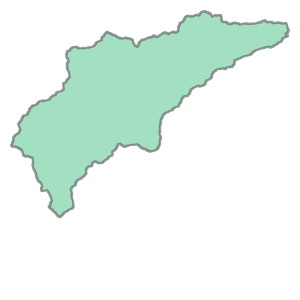

In [47]:
watershed.exterior()

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [48]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
# use 10-m DEM instead
# sources['DEM'] = workflow.source_list.dem_sources['NED 1/3 arc-second']
workflow.source_list.log_sources(sources)

2021-08-11 16:47:50,253 - root - INFO: Using sources:
2021-08-11 16:47:50,254 - root - INFO: --------------
2021-08-11 16:47:50,255 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-08-11 16:47:50,256 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-08-11 16:47:50,256 - root - INFO: DEM: National Elevation Dataset (NED)
2021-08-11 16:47:50,257 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2021-08-11 16:47:50,258 - root - INFO: geologic structure: GLHYMPS version 2.0
2021-08-11 16:47:50,259 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2021-08-11 16:47:50,259 - root - INFO: soil thickness: None
2021-08-11 16:47:50,259 - root - INFO: meteorology: DayMet 1km


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

## import river shapes

In [49]:
simplify = 50 # unit in crs, this may be useful to smooth both river segments and huc boundary

In [50]:
with open("./results/ARW_rivers_ignore2_prune1_simplify50.p", "rb") as f:
    rivers = pickle.load(f)
    
workflow.split_hucs.simplify(watershed, simplify)

In [ ]:
# # find what HUC our shape is in
# huc = workflow.find_huc(sources['HUC'], watershed.exterior(), crs, hint = '1703', shrink_factor=0.1)
# logging.info("Found watershed in HUC: {}".format(huc))

In [31]:
huc = "1703000201" # provide the HUC8 for NHD or HUC4 for NHDPlus that includes that watershed
simplify = 50 # unit in crs, this may be useful to smooth both river segments and huc boundary

rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, 
                                         cut_intersections=True,
                                        ignore_small_rivers=2, prune_by_area_fraction=0.01
                                        )

else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)



2021-08-11 16:33:45,932 - root - INFO: 
2021-08-11 16:33:45,933 - root - INFO: Preprocessing Hydrography
2021-08-11 16:33:45,933 - root - INFO: ------------------------------
2021-08-11 16:33:45,934 - root - INFO: Loading streams in HUC 1703000201
2021-08-11 16:33:45,934 - root - INFO:          and/or bounds (422044.9579910975, 164670.50734242608, 449125.96042868716, 184763.42768634777)
2021-08-11 16:33:45,936 - root - INFO: Using Hydrography file "/Users/shua784/github/workflow-test/examples/data/hydrography/NHDPlus_H_1703_GDB/NHDPlus_H_1703.gdb"
2021-08-11 16:33:47,474 - root - INFO:   found 0 reaches
2021-08-11 16:33:47,474 - root - INFO: 
2021-08-11 16:33:47,475 - root - INFO: Simplifying and pruning
2021-08-11 16:33:47,475 - root - INFO: ------------------------------
2021-08-11 16:33:47,475 - root - INFO: Filtering rivers outside of the HUC space
2021-08-11 16:33:47,476 - root - INFO:   filtered from 0 to 0 reaches.


In [23]:
# with open("./results/ARW_rivers_ignore2_prune1_simplify50.p", "wb") as f:
#     pickle.dump(rivers, f, protocol=-1)

### plot watershed bnd and river networks

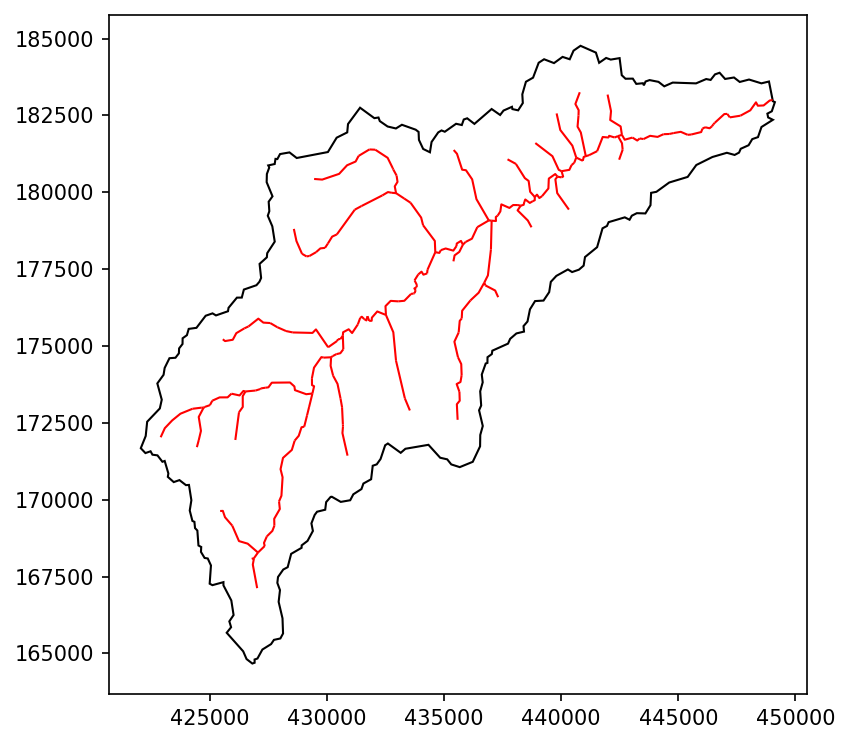

In [51]:
# plot what we have so far -- an image of the HUC and its stream network
fig,ax = plt.subplots(1,1, figsize=(6,6))
# ax = workflow.plot.get_ax(crs, fig)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

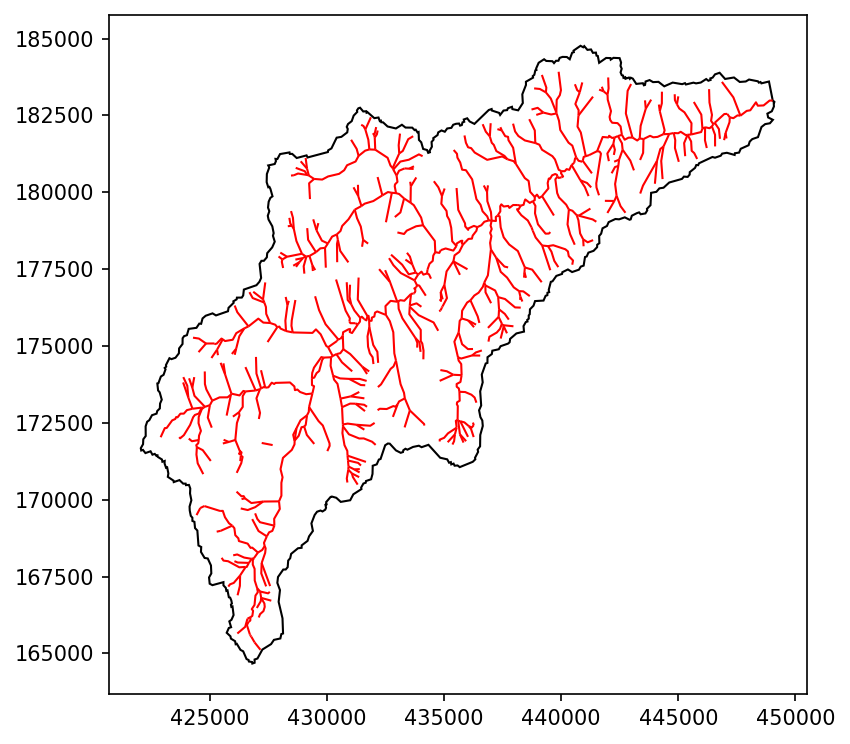

In [17]:
# before prune

2021-08-11 16:48:02,740 - root - INFO: 
2021-08-11 16:48:02,741 - root - INFO: Meshing
2021-08-11 16:48:02,741 - root - INFO: ------------------------------
2021-08-11 16:48:02,744 - root - INFO: Triangulating...
2021-08-11 16:48:02,745 - root - INFO:    257 points and 257 facets
2021-08-11 16:48:02,746 - root - INFO:  checking graph consistency
2021-08-11 16:48:02,746 - root - INFO:  tolerance is set to 1
2021-08-11 16:48:02,749 - root - INFO:  building graph data structures
2021-08-11 16:48:02,752 - root - INFO:  triangle.build...
2021-08-11 16:48:02,752 - root - WARNING: Triangulate: '--enforce-delaunay' option requires a hacked `meshpy.triangle`.  Proceeding without this option because it is not recognized.
2021-08-11 16:48:05,041 - root - INFO:   ...built: 4101 mesh points and 7854 triangles
2021-08-11 16:48:05,042 - root - INFO: Plotting triangulation diagnostics
2021-08-11 16:48:05,852 - root - INFO:   min area = 2436.565872192383
2021-08-11 16:48:05,853 - root - INFO:   max are

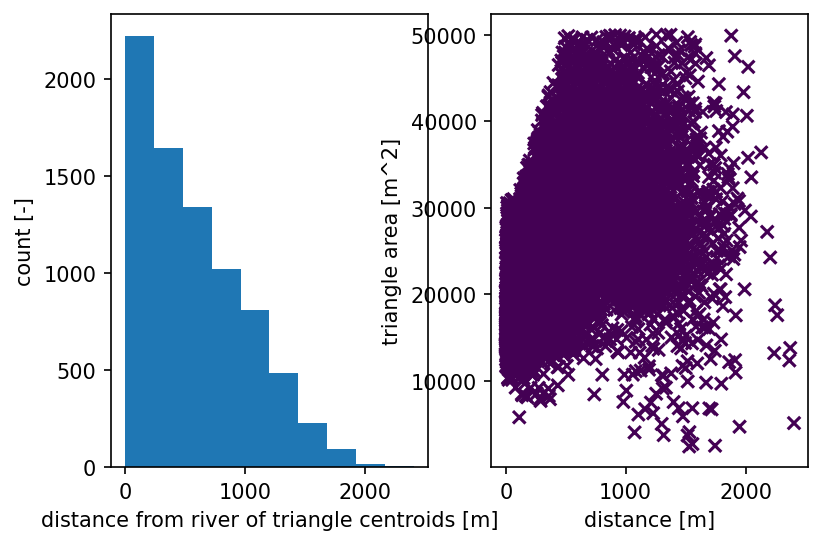

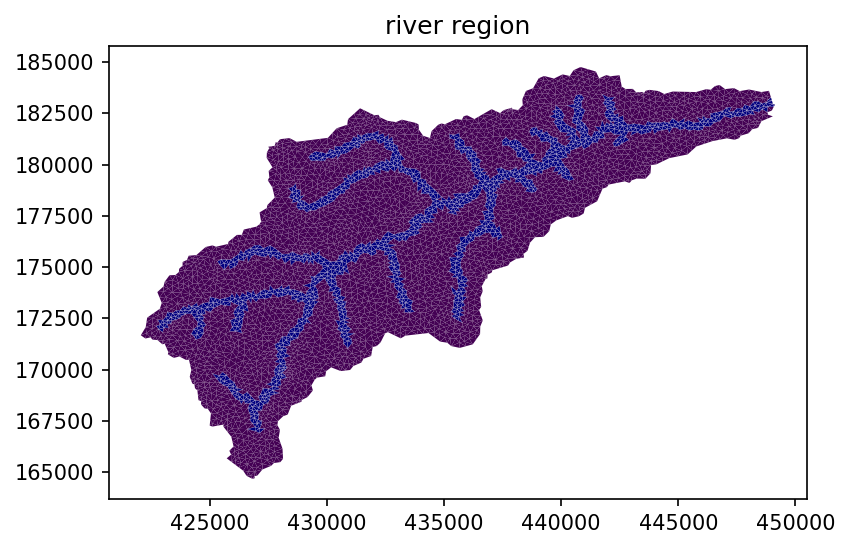

In [52]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.

# d0 = 10; d1 = 100
d0 = 100; d1 = 500

# A0 = 50; A1 = 50000 # [40, 310]m
# A0 = 1000; A1 = 50000 # [40, 310]m
# A0 = 1250; A1 = 50000 # [50, 310]m
# A0 = 5000; A1 = 50000 # [~100, 310]m
# A0 = 10000; A1 = 50000 # [~140, 310]m
# A0 = 20000; A1 = 50000 # [~200, 310]m
A0 = 31250; A1 = 50000 # [250, 310]m
# A0 = 50000; A1 = 50000 # [~310, 310]m

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, distances, river_idx = workflow.triangulate(watershed, rivers,                                                 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               enforce_delaunay=True,
                                               diagnostics=True,
                                                river_region_dist = 200)

In [96]:
# np.savetxt(fname_river_idx, river_idx, fmt='%1d')

## Download DEM

2021-08-31 10:42:04,096 - root - INFO: 
2021-08-31 10:42:04,098 - root - INFO: Preprocessing Raster
2021-08-31 10:42:04,099 - root - INFO: ------------------------------
2021-08-31 10:42:04,109 - root - INFO: collecting raster
2021-08-31 10:42:04,944 - root - INFO: Collecting DEMs to tile bounds: [-121.57200647685217, 46.773859900905435, -121.11924296932739, 47.02995636809854]
2021-08-31 10:42:04,946 - root - INFO:   Need:
2021-08-31 10:42:04,947 - root - INFO:     /Users/shua784/github/workflow-test/examples/data/dem/USGS_NED_1as_n47_w122.img
2021-08-31 10:42:04,947 - root - INFO:     /Users/shua784/github/workflow-test/examples/data/dem/USGS_NED_1as_n48_w122.img
2021-08-31 10:42:04,949 - root - INFO: source files already exist!
2021-08-31 10:42:05,072 - root - INFO: Got raster of shape: (922, 1630)
2021-08-31 10:42:05,073 - root - INFO: resamping raster using bilinear method...
2021-08-31 10:42:05,242 - root - INFO: smoothing using Gaussian filter with sigma = 3...
2021-08-31 10:42:0

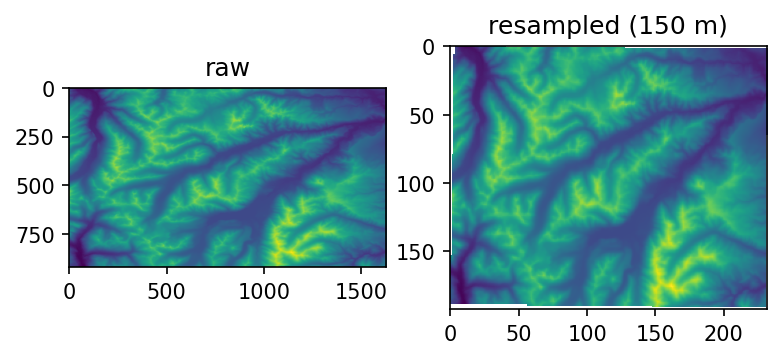

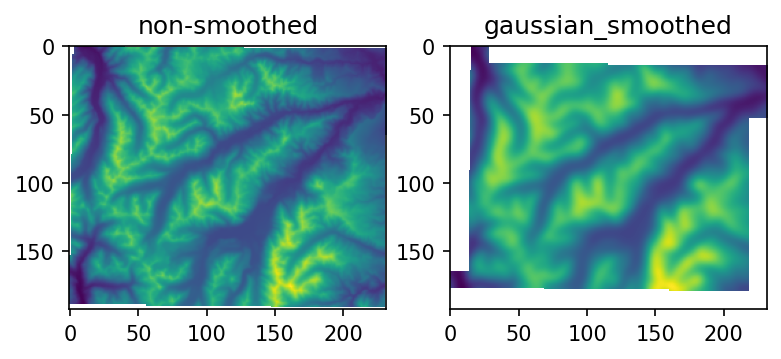

<Figure size 900x600 with 0 Axes>

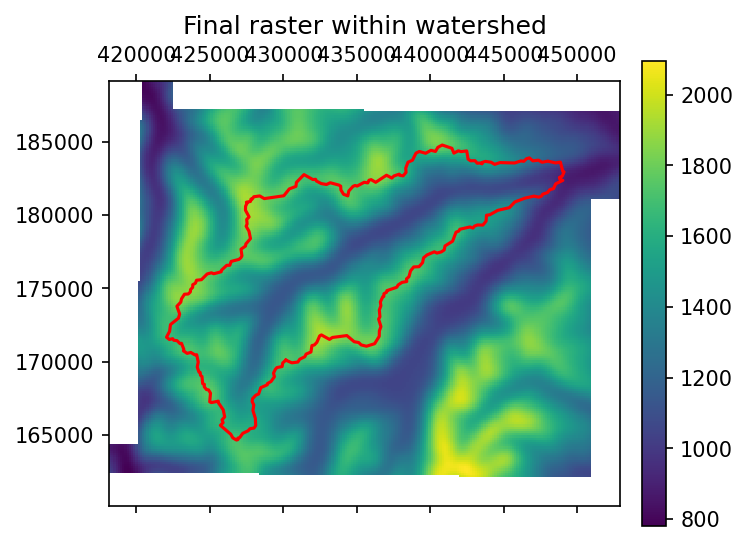

In [61]:
# get a raster for the elevation map, based on NED
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs, 
                                                buffer = 3000, 
                                                resampling_res= 150, smooth_sigma = 3,
                                                plot = True, 
                                                 )

### Map mesh to DEM

In [62]:
# elevate the triangle nodes to the dem
mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile)

2021-08-31 10:42:09,621 - root - INFO: 
2021-08-31 10:42:09,622 - root - INFO: Elevating Triangulation to DEM
2021-08-31 10:42:09,622 - root - INFO: ------------------------------


Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

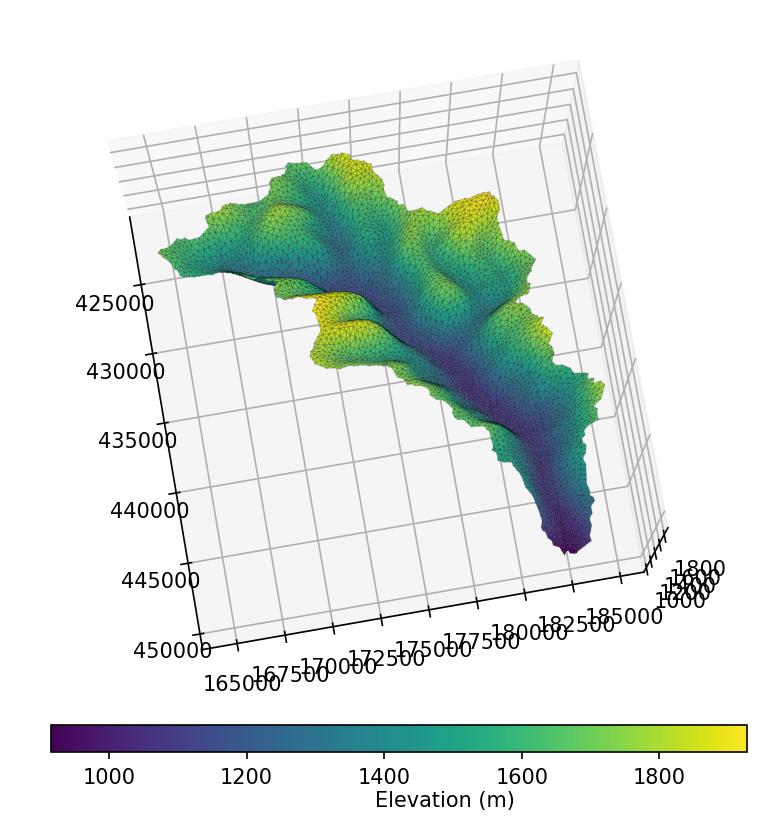

In [27]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

# t = cax.set_title('elevation [m]')
plt.text(0.5, -0.1, 'Elevation (m)', transform=ax.transAxes)

ax.view_init(80,-10)
# ax.set_xticklabels(list())
# ax.set_yticklabels(list())

# fig.savefig(fig_mesh3D, dpi = 300, transparent= True)

In [23]:
# visualize in animation
def animate(frame):
    ax.view_init(80, frame/4)
    plt.pause(.001)
    return fig

anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
HTML(anim.to_html5_video())

2021-01-06 16:44:08,202 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-06 16:44:08,204 - matplotlib.animation - INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x900 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/b_/kpbcrn3s4_1770_6k278969jd__sdl/T/tmp9_yfdonf/temp.m4v


(420690.9078692189, 450480.0105505666)
(163665.86095, 185768.07405000005)


Text(0.5, 1.0, 'Elevation [m]')

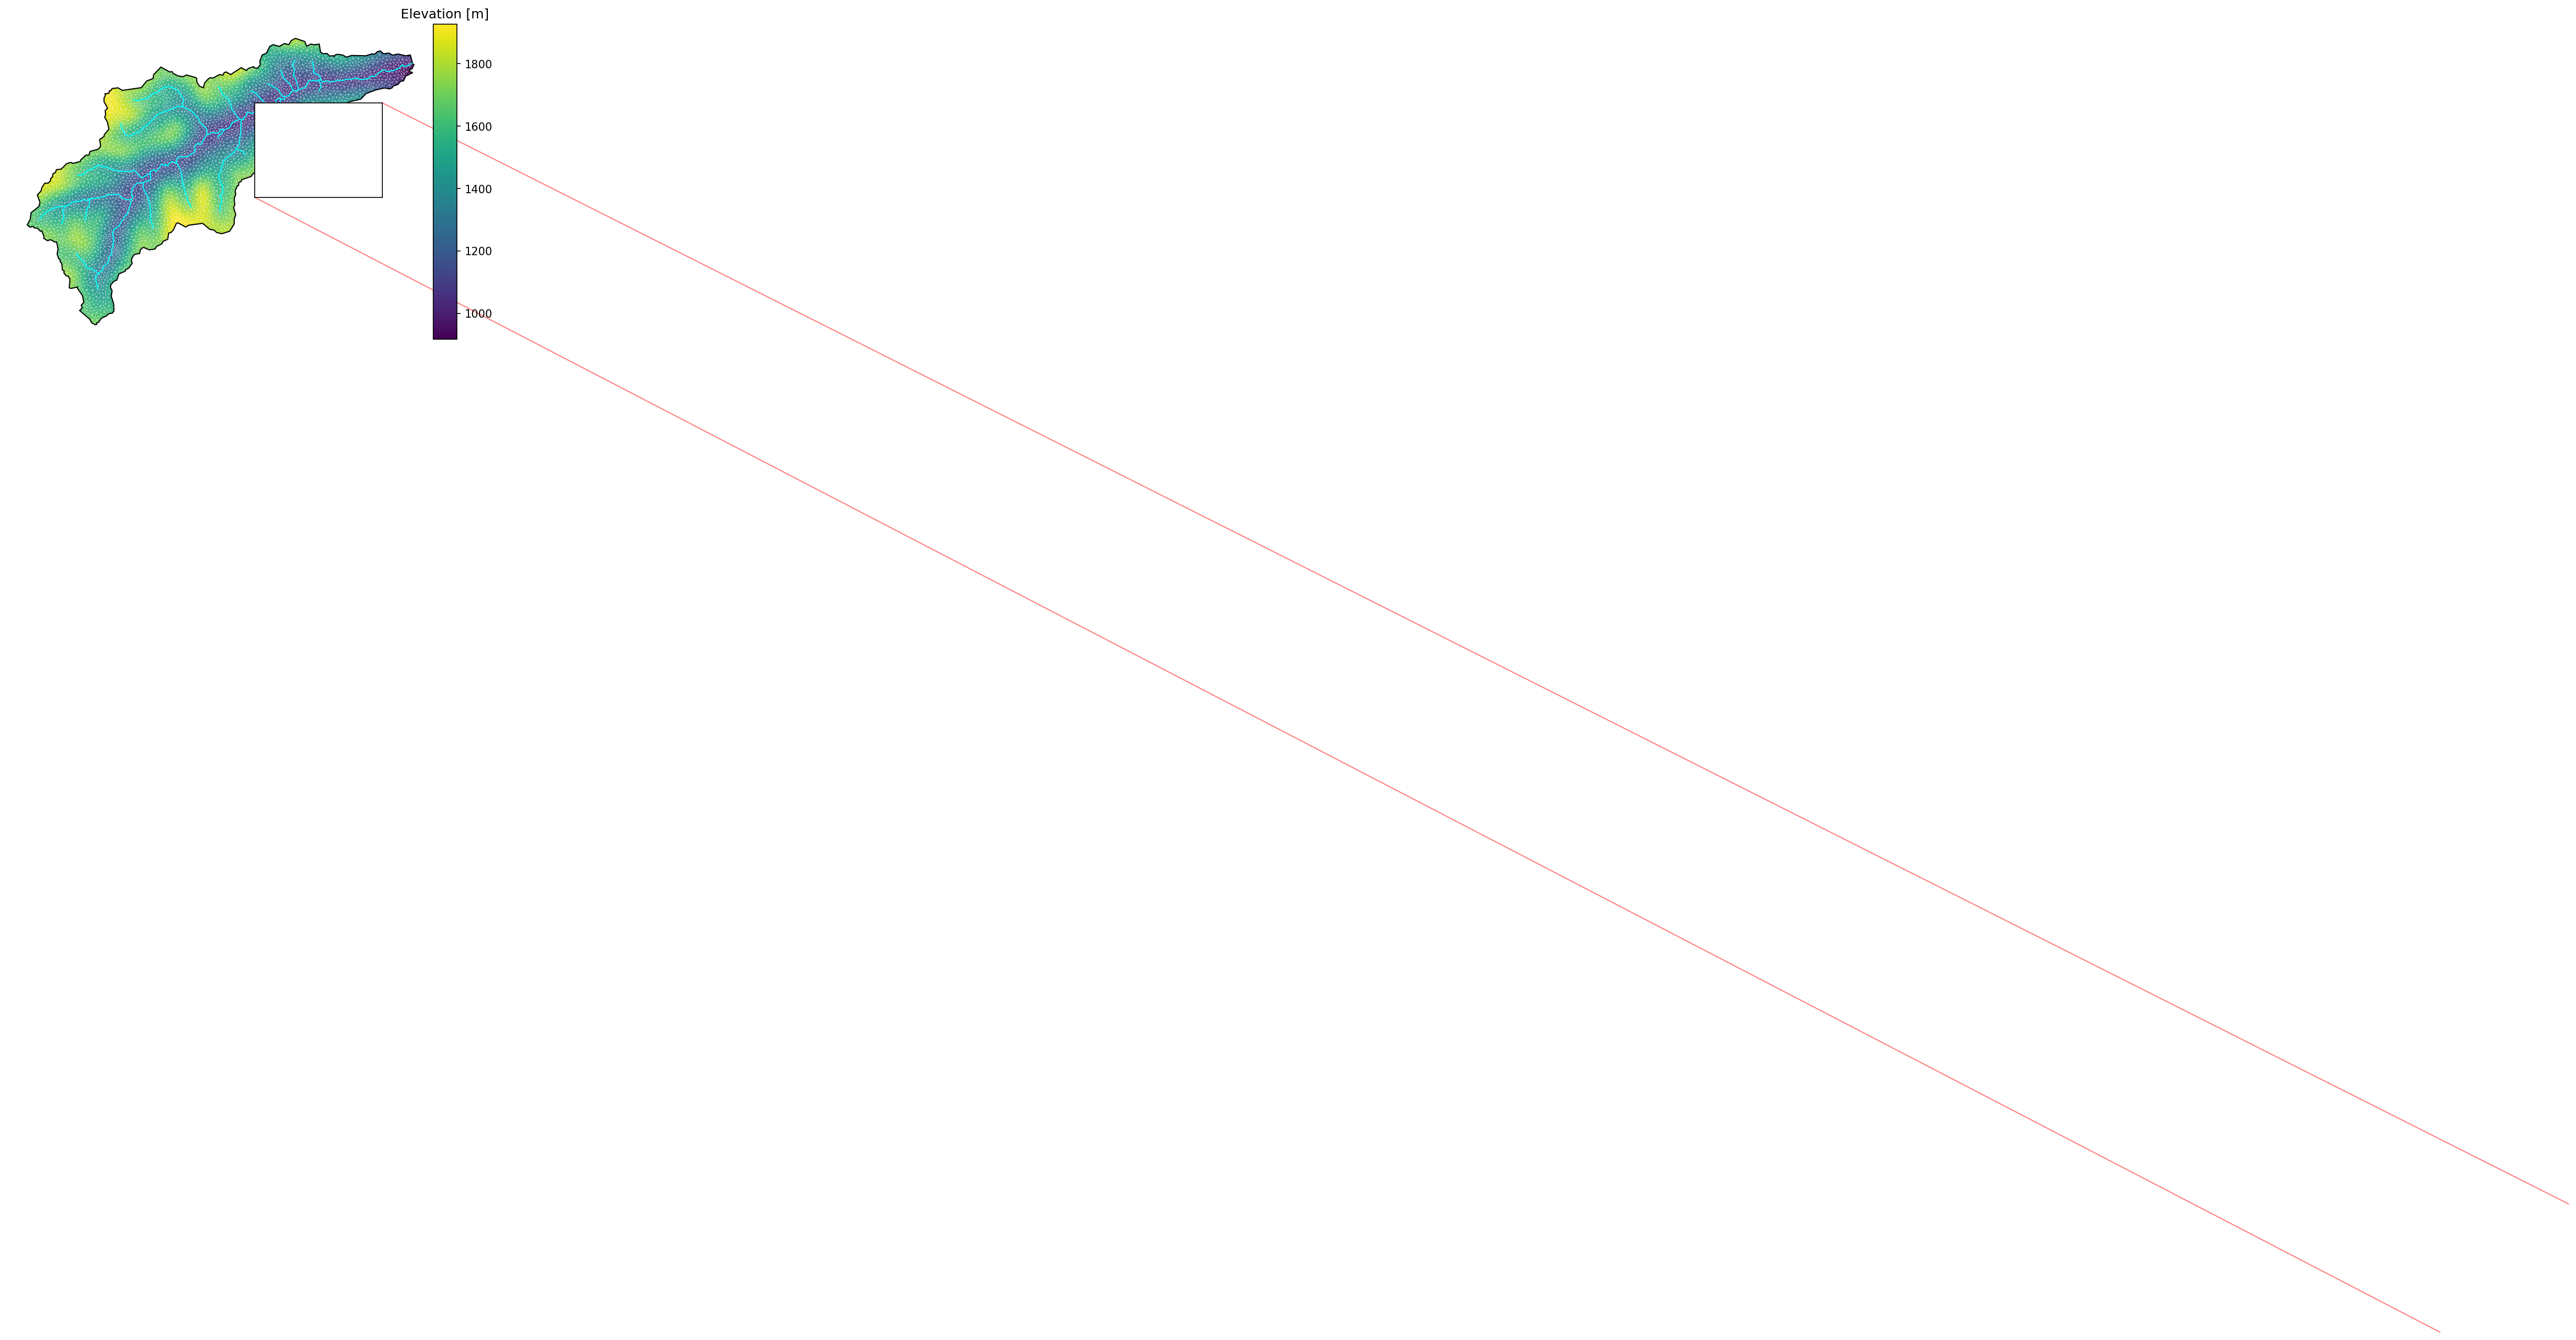

In [66]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(6,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
ax2 = ax.inset_axes([0.58,0.45,0.3,0.3])
# cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

bxlim = (591000., 600000.)
bylim = (94000., 103000.)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')
# ax.set_xlim([770000, 800000])
# ax.set_ylim([4520000, 4550000])

mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color='elevation', edgecolor='white', linewidth=0.5)
workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax2, color='aqua', linewidth=1.5)
ax2.set_xlim(bxlim)
ax2.set_ylim(bylim)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_aspect('equal', 'datalim')

ax.indicate_inset_zoom(ax2, edgecolor='r')

# ax.margins(0.5)
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
# scalebar1 = ScaleBar(1, location = "lower left")
# ax.add_artist(scalebar1)
# scalebar2 = ScaleBar(1, location = "upper right")

# ax2.add_artist(scalebar2)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('Elevation [m]')

# fig.tight_layout()
# fig.savefig(fig_mesh, dpi = 300, transparent = True)

(420690.9078692189, 450480.0105505666)
(163665.86095, 185768.07405000005)


Text(0.5, 1.0, 'Elevation [m]')

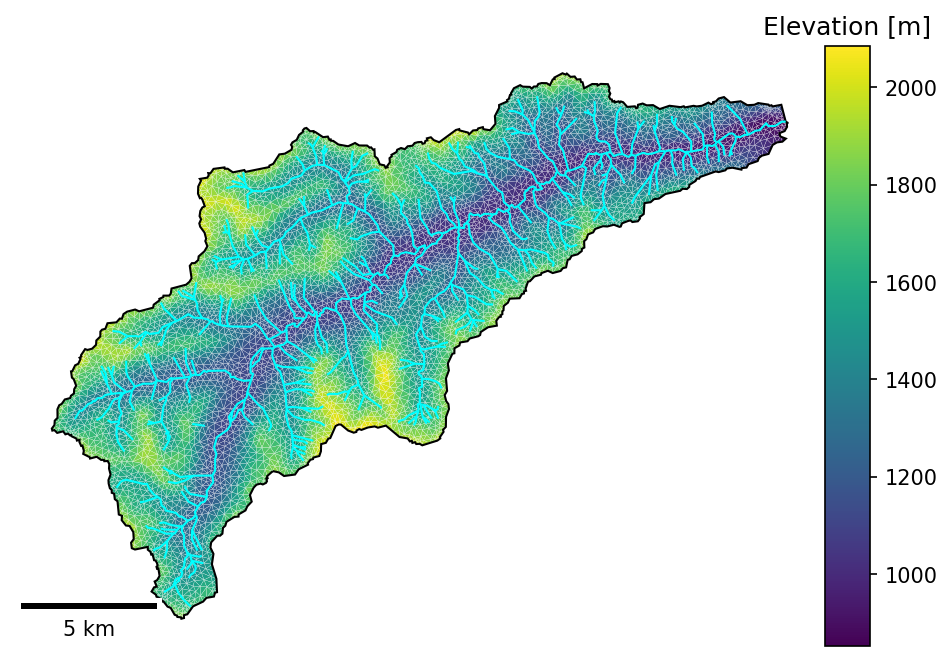

In [18]:
# with open(fname_mesh_pickle, 'wb') as f:
#     pickle.dump((mesh_points3, mesh_points2, mesh_tris), f, protocol=-1)

### construct 2d mesh 

In [112]:
# with open(fname_mesh_pickle, 'rb') as f:
#     mesh_points3, mesh_points2, mesh_tris = pickle.load(f)

In [29]:
# construct the 2D mesh
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

### Hydrologically condition the mesh

2021-06-08 21:21:52,448 - root - INFO: max diff = 35.12978351612492 


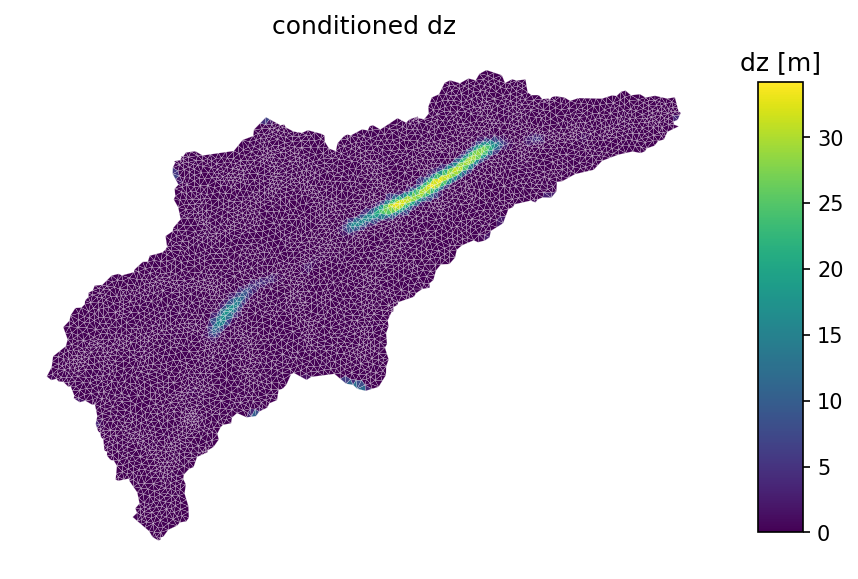

In [30]:
# hydrologically condition the mesh
workflow.condition.condition(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
logging.info(f"max diff = {np.abs(diff[:,2]).max()} ")
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
cbax = fig.add_axes([.95,0.25,0.05,0.5])

mp = workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='white', 
                            linewidth=0.1, ax=ax)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
cbar.ax.set_title('dz [m]')
ax.axis('off')
ax.set_title('conditioned dz')
plt.show()

### Export surface mesh

In [115]:
# m2.write_VTK(fname_surface_mesh)

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [119]:
# m2 = workflow.mesh.Mesh2D.read_VTK(fname_surface_mesh)

In [31]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs,
                                                     )

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2021-06-08 21:22:00,657 - root - INFO: 
2021-06-08 21:22:00,658 - root - INFO: Preprocessing Raster
2021-06-08 21:22:00,659 - root - INFO: ------------------------------
2021-06-08 21:22:00,659 - root - INFO: collecting raster
2021-06-08 21:22:00,675 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2021-06-08 21:22:00,807 - root - INFO: Got raster of shape: (542, 973)
2021-06-08 21:22:00,807 - root - INFO: Raster bounds: (-193

In [32]:
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

In [33]:
area_list = [areas[lc==i].sum() for i in nlcd_indices]
area_coverage = np.array(area_list) / areas.sum() * 100

nlcd_df = pd.DataFrame([nlcd_indices, nlcd_labels, area_list]).T
nlcd_df.columns = ['id', 'name', 'area']
nlcd_df.set_index('id', inplace = True)

nlcd_df['coverage [%]'] = area_coverage

nlcd_df.to_csv(fname_nlcd)

(420690.9079, 450480.0101, 163665.86095, 185768.07405000002)

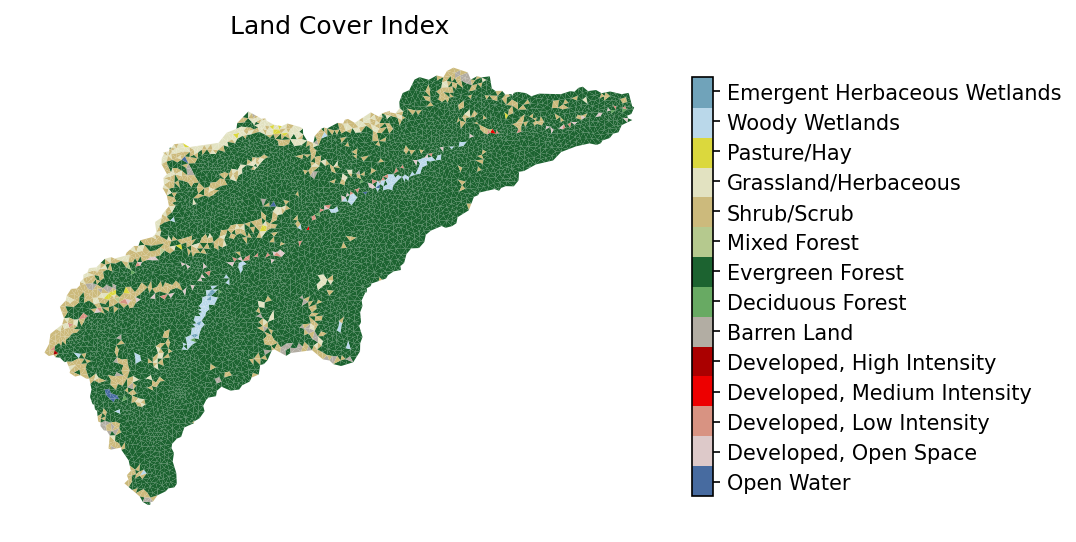

In [34]:
# plot the image
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)

workflow.colors.colorbar_index(ncolors=len(np.unique(lc)), cmap=nlcd_cmap, labels = nlcd_labels) 

ax.set_title("Land Cover Index")
ax.axis('off')
# fig.tight_layout()
# fig.savefig(fig_land_cover, dpi = 300, transparent = True)

## Subsurface properties

In [ ]:
# download the NRCS soils data as shapes and project it onto the mesh
import matplotlib.cm

# -- download the shapes
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))
_, soil_survey, soil_survey_props = workflow.get_shapes(sources['soil structure'], target_bounds, crs, 
                                                        properties=True
                                                       )
# _, soil_survey = workflow.get_shapes(sources['soil structure'], target_bounds, crs)

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['id'] for shp in soil_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_raster, soil_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, soil_survey,
                                              soil_ids, crs)

# -- resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)

In [68]:
area_list = [areas[soil_color==i].sum() for i in np.unique(soil_color)]
assert(np.sum(area_list) == areas.sum())
area_coverage = np.array(area_list) / areas.sum() * 100

soil_survey_props.set_index('mukey', inplace = True)
# sub_soil_props = soil_survey_props.loc[unique_soil_id,:]
soil_id_df = pd.DataFrame(np.array(np.unique(soil_color, return_counts=True)).T, columns = ['mukey', 'count'])
soil_id_df.set_index('mukey', inplace = True)
soil_id_df['area'] = area_list
soil_id_df['coverage [%]'] = area_coverage

soil_prop_df = soil_survey_props.merge(soil_id_df, how = 'inner', left_on='mukey', right_on = 'mukey', sort = True)
soil_prop_df.to_csv(fname_soil_prop)

In [ ]:
# print(soil_survey_props)

In [36]:
# soil_survey_props.to_csv(fname_soil_prop, index = False)

In [6]:
soil_prop_df = pd.read_csv("/Users/shua784/github/yakima/data/material/American_soil_prop-250m-riverbed-gapfill.csv",
                          index_col='mukey'
                          )

/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(420646.31965, 451406.66134999995, 163794.452, 185810.094)

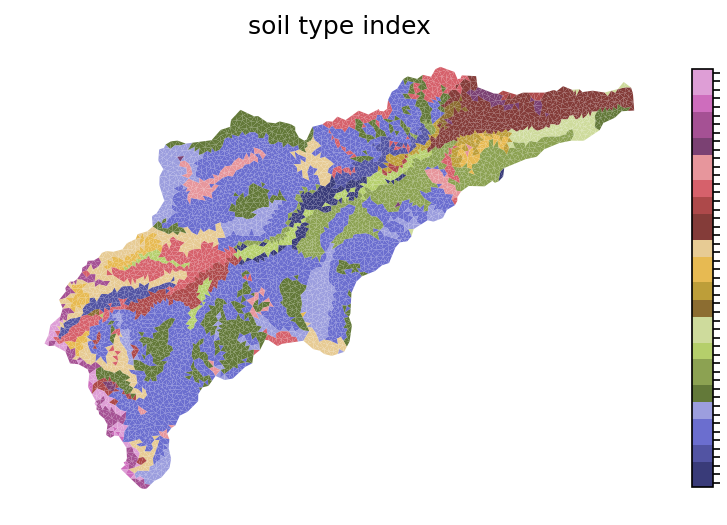

In [130]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_color, cmap = 'tab20b')

# plot the soil mukey
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm = norm
                       )

workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), cmap=cmap, labels = '', fraction = 0.03) 

ax.set_title('soil type index')
ax.axis('off')
# fig.savefig('watershed_soils')

Median soil thickness [m] =  nan


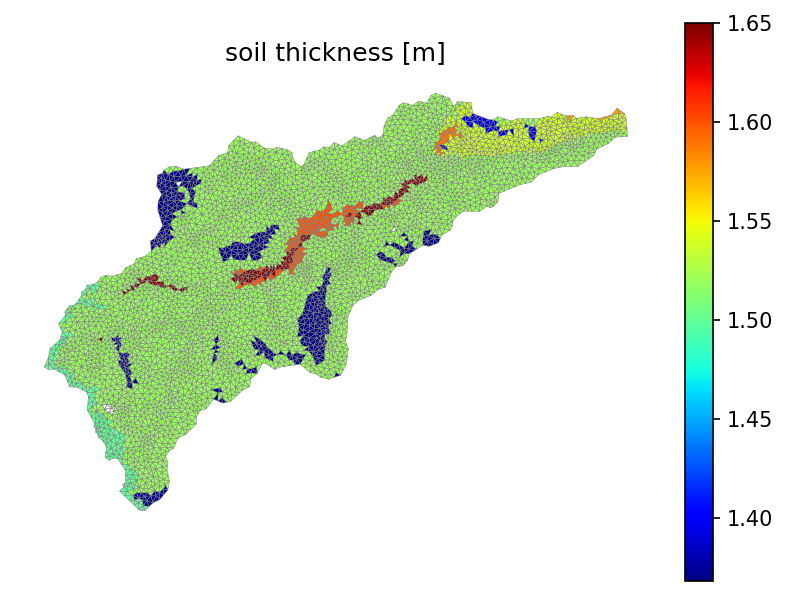

In [54]:
# what do soil thicknesses look like?
fig = plt.figure(figsize=figsize)
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'thickness [cm]']

ax = workflow.plot.get_ax(crs, fig)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop/100, edgecolor='gray', cmap='jet')
# cbar = fig.colorbar(mp)
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
# cb.ax.set_title('[m]')
# cb.set_ticks(nlcd_ticks)
# cb.set_ticklabels(nlcd_labels_fw)
# ax.set_title("Land Cover Index")
ax.axis('off')

print('Median soil thickness [m] = ', np.median(iprop)/100)

# fig.savefig('watershed_soil_thickness')


Median soil thickness [m] =  0.4123684210526316


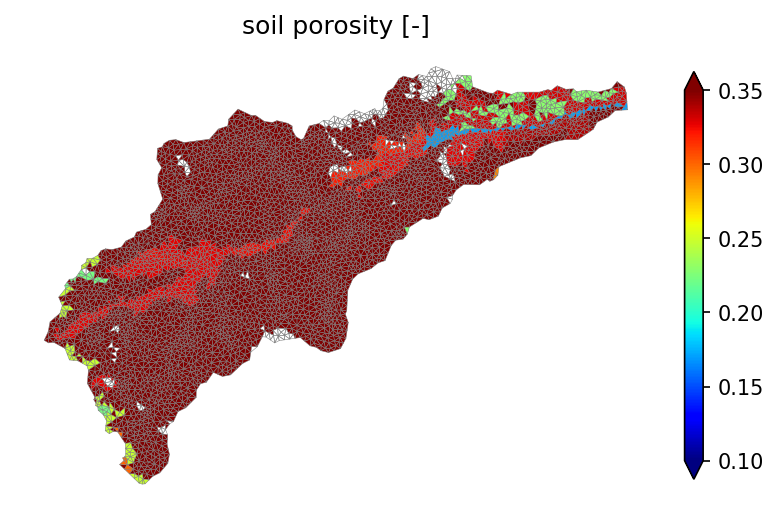

In [55]:
# what do soil thicknesses look like?
fig = plt.figure(figsize=figsize)
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'porosity [-]']

ax = workflow.plot.get_ax(crs, fig)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet', vmin = 0.1, vmax = 0.35)
# cbar = fig.colorbar(mp)
ax.set_title('soil porosity [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
# cb.ax.set_title('[m]')
# cb.set_ticks(nlcd_ticks)
# cb.set_ticklabels(nlcd_labels_fw)
# ax.set_title("Land Cover Index")
ax.axis('off')

print('Median soil thickness [m] = ', np.nanmedian(iprop))

# fig.savefig('watershed_soil_thickness')


Min k [m^2] =  2.0937843947447842e-13


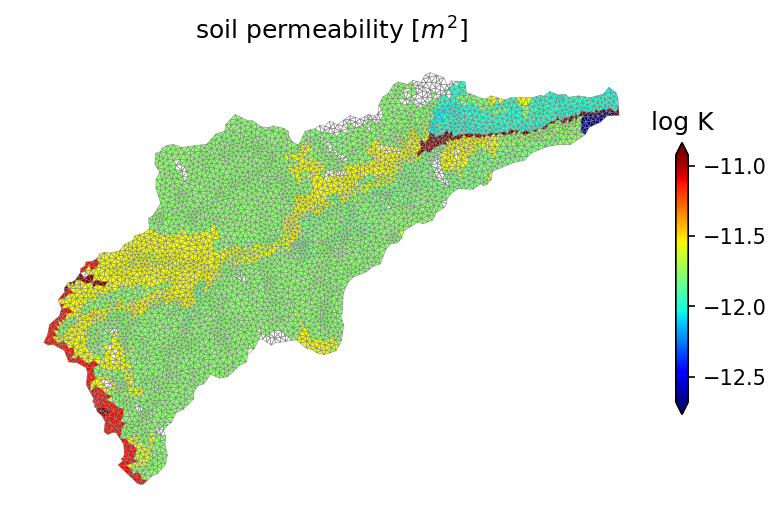

In [56]:
# plot of permeability
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'permeability [m^2]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(iprop), edgecolor='gray', cmap='jet')
ax.set_title('soil permeability [$m^2$]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
cb.ax.set_title('log K')
ax.axis('off')

print('Min k [m^2] = ', np.nanmin(iprop))

### k-mean clustering

In [7]:
from sklearn.cluster import KMeans

In [22]:
soil_prop_df = pd.read_csv("/Users/shua784/github/yakima/data/material/American_soil_prop-250m-riverbed-gapfill-clustered.csv",
                          index_col='mukey'
                          )

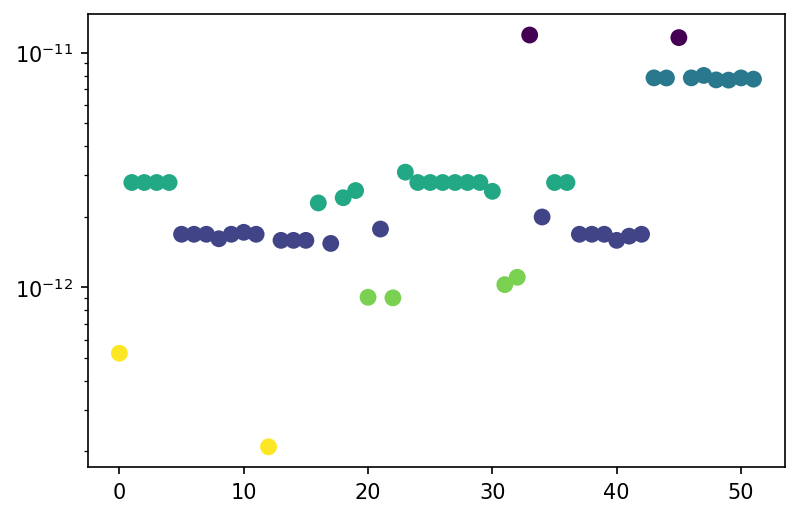

In [19]:
kmeans = KMeans(n_clusters=6) # vary number of clusters to tweak results
X= soil_prop_df['permeability [m^2]'].values.reshape(-1, 1)
kmeans.fit(X)
y_kmeans = kmeans.predict(X) # the group will change randomly?

plt.scatter(np.arange(X.shape[0]), X[:, 0], c=y_kmeans, s=50, cmap='viridis')
plt.yscale('log')
# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [20]:
cluster = y_kmeans + 1 # convert to 1-based index
soil_prop_df['cluster'] = cluster

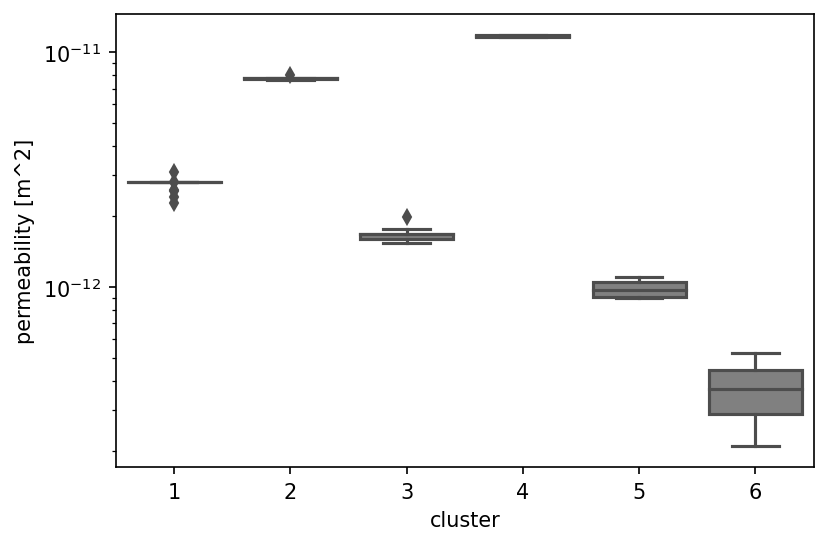

In [23]:
import seaborn as sns
sns.boxplot(x = 'cluster', y = 'permeability [m^2]', data = soil_prop_df, color = 'gray')
plt.yscale('log')

In [24]:
for i in np.unique(cluster):
    ids = soil_prop_df[soil_prop_df['cluster'] == i].index
    logging.info(f"cluster {i}: {ids}")
    

2021-09-07 13:35:29,655 - root - INFO: cluster 1: Int64Index([75322, 75327, 75328, 75334, 75392, 75398, 75403, 75440, 75462,
            75482, 75485, 75506, 75508, 75511, 75514, 75661, 75670],
           dtype='int64', name='mukey')
2021-09-07 13:35:29,657 - root - INFO: cluster 2: Int64Index([2756442, 2901079, 2901081, 2901082, 2901083, 2901084, 2901085,
            2901086],
           dtype='int64', name='mukey')
2021-09-07 13:35:29,658 - root - INFO: cluster 3: Int64Index([ 75339,  75340,  75342,  75343,  75349,  75351,  75352,  75357,
             75359,  75361,  75394,  75413,  75654,  75691,  75693,  75694,
             75695,  75696, 679189],
           dtype='int64', name='mukey')
2021-09-07 13:35:29,659 - root - INFO: cluster 4: Int64Index([75618, 2901080], dtype='int64', name='mukey')
2021-09-07 13:35:29,661 - root - INFO: cluster 5: Int64Index([75404, 75414, 75572, 75586], dtype='int64', name='mukey')
2021-09-07 13:35:29,662 - root - INFO: cluster 6: Int64Index([75318, 753

In [25]:
# soil_prop_df['cluster'] = cluster
soil_prop_df['logK'] = np.log10(soil_prop_df['permeability [m^2]'])
soil_prop_df['VGM_m'] = 1- 1/ (soil_prop_df['van Genuchten n [-]'])
soil_prop_df['logAlpha'] = np.log10(soil_prop_df['van Genuchten alpha [Pa^-1]'])

In [26]:
10**(soil_prop_df.groupby('cluster').mean()[['logAlpha']])

logAlpha
cluster          
1        0.000082
2        0.000092
3        0.000089
4        0.000189
5        0.000077
6        0.000070

In [27]:
soil_prop_df.groupby('cluster').mean()[[ 'VGM_m', 'residual saturation [-]', 'porosity [-]']]

VGM_m  residual saturation [-]  porosity [-]
cluster                                                 
1        0.333908                 0.148058      0.339403
2        0.351618                 0.136426      0.370137
3        0.330638                 0.151955      0.433716
4        0.469505                 0.137251      0.197469
5        0.303987                 0.189188      0.350712
6        0.279954                 0.223516      0.362171

In [28]:
soil_meanK = 10**(soil_prop_df.groupby('cluster').mean()[['logK']])

soil_meanK

logK
cluster              
1        2.732650e-12
2        7.785262e-12
3        1.671760e-12
4        1.175208e-11
5        9.824107e-13
6        3.313456e-13

In [131]:
new_soil_color = soil_color.copy()
for i in set(cluster):
    isoil = soil_prop_df[soil_prop_df['cluster'] == i].index
    idx = np.isin(new_soil_color, isoil)
    new_soil_color[idx] = int(i)  

In [132]:
np.unique(new_soil_color)

array([1, 2, 3, 4, 5, 6], dtype=int32)

/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(420646.31965, 451406.66134999995, 163794.452, 185810.094)

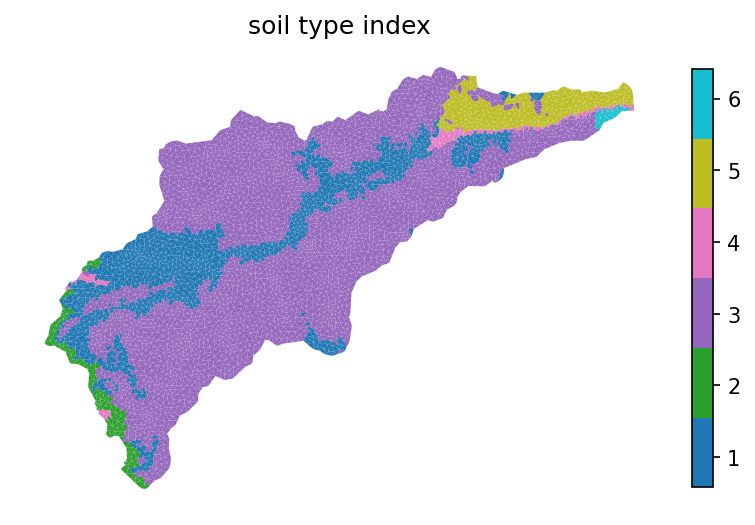

In [133]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(new_soil_color, cmap = 'tab10')

# plot the soil mukey
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

polys = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=new_soil_color, 
                        cmap=cmap, norm = norm
                       )
workflow.colors.colorbar_index(ncolors=len(np.unique(new_soil_color)), cmap=cmap, labels = labels) 
 
ax.set_title('soil type index')
ax.axis("off")
# fig.savefig('watershed_soils')

In [137]:
soil_prop_df.to_csv("/Users/shua784/github/yakima/data/material/American_soil_prop-250m-riverbed-gapfill-clustered.csv")

## map geology

Manually download global geology map (GLHYMPS v2.0) from [here](https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/TTJNIU), and put it under `./data/soil_structure/GLHYMPS`. The file size is about ~4 GB.

In [36]:
target_bounds = watershed.exterior().bounds

_, geo_survey, geo_survey_props = workflow.get_shapes(sources['geologic structure'], target_bounds, crs, properties=True)

# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_raster, geo_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, geo_survey,
                                              geo_ids, crs)

# -- resample the raster to the triangles
geo_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         geo_color_raster, geo_color_profile)

2021-06-08 21:24:03,959 - root - INFO: 
2021-06-08 21:24:03,960 - root - INFO: Preprocessing Shapes
2021-06-08 21:24:03,960 - root - INFO: ------------------------------
2021-06-08 21:24:04,096 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
../../workflow-test/workflow/sources/manager_shape.py:76: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  shps = [s for (i,s) in fid.items(bbox=bounds)]
2021-06-08 21:24:35,874 - root - INFO: shape union bounds: (386911.3214970341, 112379.03856700905, 558658.3888897153, 233173.46442265552)
2021-06-08 21:24:35,874 - root - INFO: Coloring shapes onto raster:
2021-06-08 21:24:35,875 - root - INFO:   target_bounds = (422044.9579910975, 164670.50734242608, 449125.96042868716, 184763.42768634777)
2021-06-08 21:24:35,875 - root - INFO:   out_bounds = [422040.0, 164668.0, 449140.0, 184768.0]
2021-06-08 21:24:35,876 - root - INFO:   pixel_size = 10
2021-06-08 21:24:35,876 

In [72]:
area_list = [areas[geo_color==i].sum() for i in np.unique(geo_color)]
assert(np.sum(area_list) == areas.sum())
area_coverage = np.array(area_list) / areas.sum() * 100

geo_survey_props.set_index('id', inplace = True)
# sub_soil_props = soil_survey_props.loc[unique_soil_id,:]
geo_id_df = pd.DataFrame(np.array(np.unique(geo_color, return_counts=True)).T, columns = ['id', 'count'])
geo_id_df.set_index('id', inplace = True)
geo_id_df['area'] = area_list
geo_id_df['coverage [%]'] = area_coverage

geo_prop_df = geo_survey_props.merge(geo_id_df, how = 'inner', left_on='id', right_on = 'id', sort = True)
geo_prop_df.to_csv(fname_geol_prop)

### plot geology map

(420690.9079, 450480.0101, 163665.86095, 185768.07405000002)

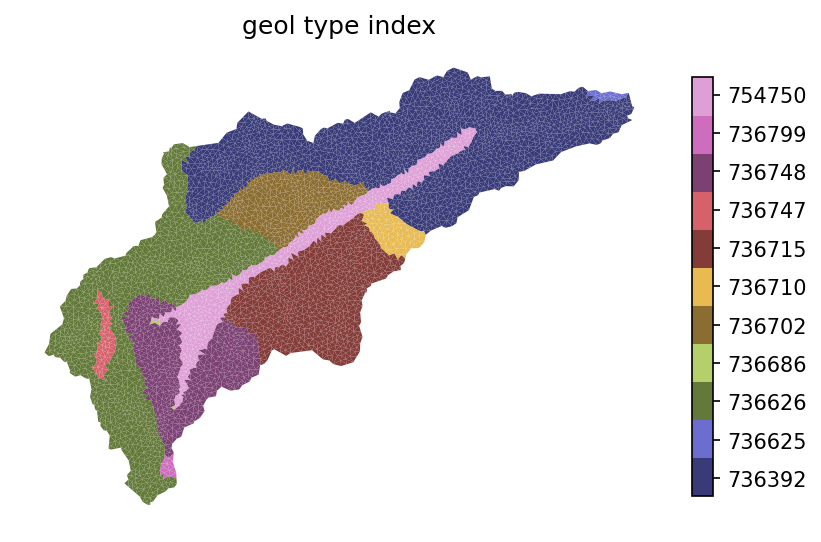

In [73]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(geo_color, cmap = 'tab20b')

# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geo_color, 
                        cmap=cmap, norm = norm
                        )

workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels = labels) 

ax.set_title('geol type index')
ax.axis('off')
# ax.legend()

# fig.savefig(fig_geol_map, dpi = 300, transparent = True)

min, max =  0.01 0.22


Text(0.5, 1.0, 'porosity')

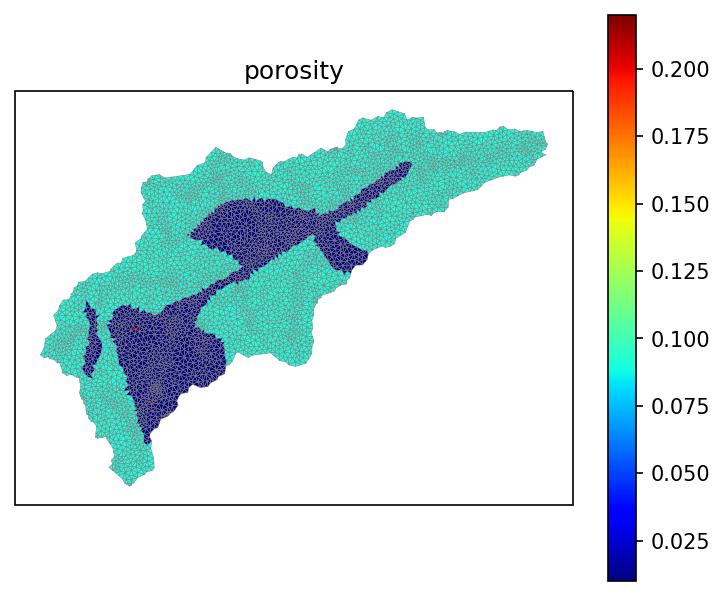

In [91]:
fig = plt.figure(figsize=(6,5))
porosity = np.empty(geo_color.shape, 'd')
# porosity_rosetta = np.empty(soil_color.shape, 'd')

for i in geo_prop_df.index:
    porosity[geo_color == i] = geo_prop_df.loc[i, 'porosity [-]']
#     porosity_rosetta[soil_color == mukey] = soil_survey_props.loc[soil_survey_props['mukey']==mukey,'Rosetta porosity [-]']

pmin = np.nanmin(porosity)
pmax = np.nanmax(porosity)
print('min, max = ', pmin, pmax)

ax1 = workflow.plot.get_ax(crs, fig, nrow=1, ncol=1, index=1)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                                 color=porosity, edgecolor='gray', cmap='jet', vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('porosity')

### k-means clustering

In [29]:
geo_prop_df = pd.read_csv("/Users/shua784/github/yakima/data/material/American_geol_prop-250m-riverbed-gapfill.csv",
                         index_col='id')

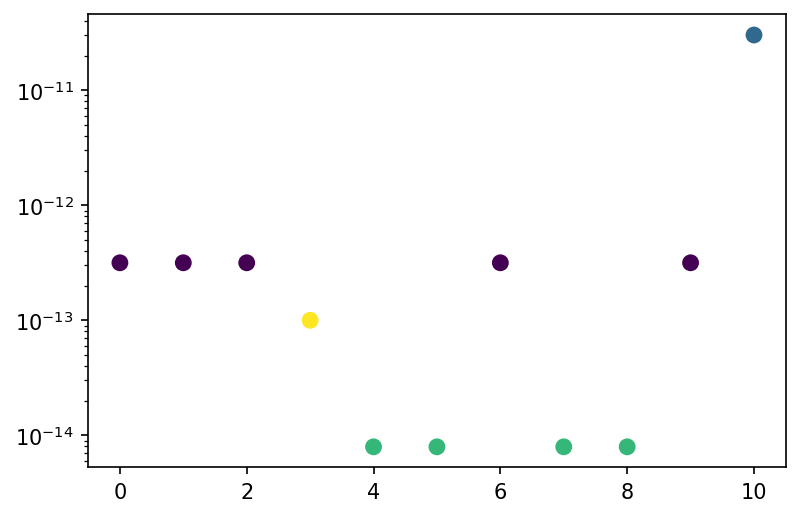

In [40]:
kmeans = KMeans(n_clusters=4)
X= geo_prop_df['permeability [m^2]'].values.reshape(-1, 1)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(np.arange(X.shape[0]), X[:, 0], c=y_kmeans, s=50, cmap='viridis')
plt.yscale('log')

In [41]:
cluster = y_kmeans + 1 # convert to 1-based index
geo_prop_df['cluster'] = cluster

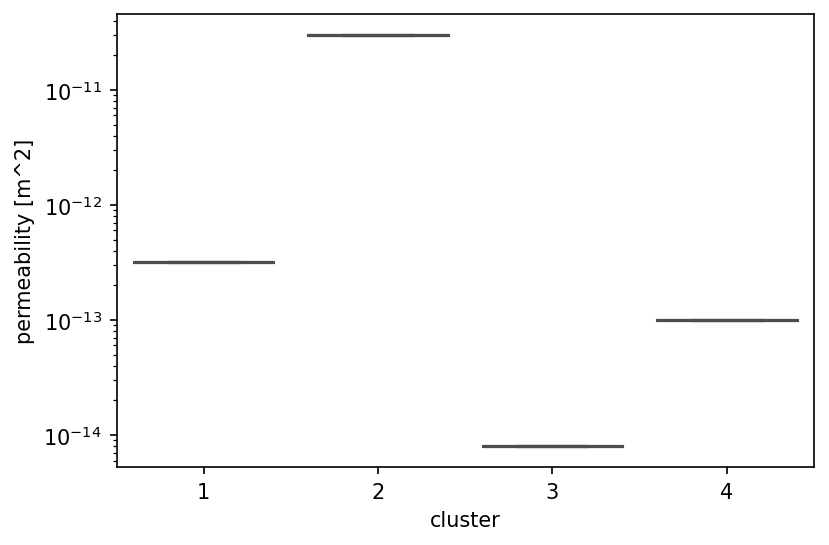

In [42]:
# import seaborn as sns
sns.boxplot(x = 'cluster', y = 'permeability [m^2]', data = geo_prop_df, color = 'gray')
plt.yscale('log')

In [44]:
geo_prop_df

source  permeability [m^2]  logk_stdev [-]  porosity [-]  \
id                                                                  
736392  GLHYMPS        3.162278e-13            1.80          0.09   
736625  GLHYMPS        3.162278e-13            1.80          0.09   
736626  GLHYMPS        3.162278e-13            1.80          0.09   
736686  GLHYMPS        1.000000e-13            2.00          0.22   
736702  GLHYMPS        7.943282e-15            1.50          0.01   
736710  GLHYMPS        7.943282e-15            1.50          0.01   
736715  GLHYMPS        3.162278e-13            1.80          0.09   
736747  GLHYMPS        7.943282e-15            1.50          0.01   
736748  GLHYMPS        7.943282e-15            1.50          0.01   
736799  GLHYMPS        3.162278e-13            1.80          0.09   
754750  GLHYMPS        3.019952e-11            1.61          0.01   

        depth to bedrock [m]  count          area  coverage [%]  cluster  
id                                                                        
736392                0.0000   2747  6.989187e+07     34.065652        1  
736625                0.0000     23  6.102377e+05      0.297433        1  
736626                0.0000   1770  4.759571e+07     23.198389        1  
736686                0.0000      3  8.020957e+04      0.039095        4  
736702                0.0000    538  1.354347e+07      6.601156        3  
736710                0.0000    139  3.991104e+06      1.945284        3  
736715                0.0000   1080  3.016356e+07     14.701874        1  
736747                0.0000     85  2.229563e+06      1.086700        3  
736748                0.0000    782  2.060897e+07     10.044915        3  
736799                0.0000     18  5.733806e+05      0.279469        1  
754750               19.2193    731  1.588008e+07      7.740033        2

In [45]:
geo_prop_df.to_csv("/Users/shua784/github/yakima/data/material/American_geol_prop-250m-riverbed-gapfill-clustered.csv")

In [48]:
for i in np.unique(cluster):
    ids = geo_prop_df[geo_prop_df['cluster'] == i].index
    logging.info(f"cluster {i}: {ids}")
    

2021-09-07 14:22:04,864 - root - INFO: cluster 1: Int64Index([736392, 736625, 736626, 736715, 736799], dtype='int64', name='id')
2021-09-07 14:22:04,865 - root - INFO: cluster 2: Int64Index([754750], dtype='int64', name='id')
2021-09-07 14:22:04,866 - root - INFO: cluster 3: Int64Index([736702, 736710, 736747, 736748], dtype='int64', name='id')
2021-09-07 14:22:04,868 - root - INFO: cluster 4: Int64Index([736686], dtype='int64', name='id')


In [49]:
geo_prop_df['logK'] = np.log10(geo_prop_df['permeability [m^2]'])
# geo_prop_df.groupby('cluster').mean()
geo_meanK = 10**(geo_prop_df.groupby('cluster').mean()[['logK']])

geo_meanK

logK
cluster              
1        3.162278e-13
2        3.019952e-11
3        7.943282e-15
4        1.000000e-13

In [47]:
geo_prop_df.groupby('cluster').mean()

permeability [m^2]  logk_stdev [-]  porosity [-]  \
cluster                                                     
1              3.162278e-13            1.80          0.09   
2              3.019952e-11            1.61          0.01   
3              7.943282e-15            1.50          0.01   
4              1.000000e-13            2.00          0.22   

         depth to bedrock [m]   count          area  coverage [%]   logK  
cluster                                                                   
1                      0.0000  1127.6  2.976695e+07     14.508563 -12.50  
2                     19.2193   731.0  1.588008e+07      7.740033 -10.52  
3                      0.0000   386.0  1.009328e+07      4.919514 -14.10  
4                      0.0000     3.0  8.020957e+04      0.039095 -13.00

In [147]:
new_geo_color = geo_color.copy()
for i in set(cluster):
    igeo = geo_prop_df[geo_prop_df['cluster'] == i].index
    idx = np.isin(new_geo_color, igeo)
    new_geo_color[idx] = int(i)  

In [148]:
np.unique(new_geo_color)

array([1, 2, 3, 4], dtype=int32)

(420646.31965, 451406.66134999995, 163794.452, 185810.094)

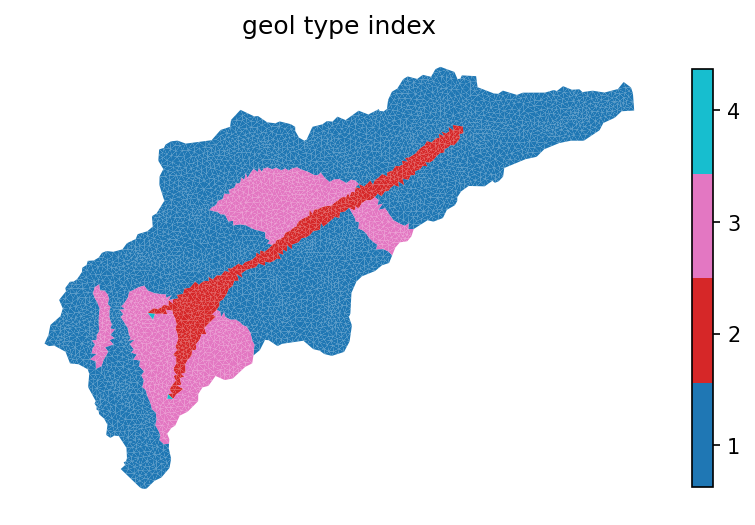

In [151]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(new_geo_color, cmap = 'tab10')

# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=new_geo_color, 
                        cmap=cmap, norm = norm
                        )

gp.colorbar_index(ncolors=len(np.unique(new_geo_color)), cmap=cmap, labels = np.unique(new_geo_color)) 

ax.set_title('geol type index')
ax.axis('off')
# print(geo_survey_props)

# fig.savefig('watershed_geology')

## get bedrock depth

Mannually download global depth to bedrock at 250 m resolution from [soilgrids](http://globalchange.bnu.edu.cn/research/dtb.jsp).

In [37]:
DTB_profile, DTB_raster = workflow.get_raster_on_shape(fname_DTB, watershed.exterior(), crs, nodata=-99999)

2021-06-08 21:24:36,302 - root - INFO: 
2021-06-08 21:24:36,302 - root - INFO: Preprocessing Raster
2021-06-08 21:24:36,303 - root - INFO: ------------------------------
2021-06-08 21:24:36,303 - root - INFO: loading file: "/Users/shua784/Dropbox/PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif"
2021-06-08 21:24:36,304 - root - INFO: collecting raster
2021-06-08 21:24:36,485 - root - INFO: Got raster of shape: (89, 171)
2021-06-08 21:24:36,485 - root - INFO: Raster bounds: (-121.522926023, 46.99500646, -121.16667608, 46.809589822999996)


In [38]:
# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB_mesh = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile)

In [39]:
logging.info(f'minimum depth-to-bedrock: {np.nanmin(DTB_mesh)} m')
logging.info(f'maximum depth-to-bedrock: {np.nanmax(DTB_mesh)} m')

2021-06-08 21:24:36,823 - root - INFO: minimum depth-to-bedrock: 6.56 m
2021-06-08 21:24:36,824 - root - INFO: maximum depth-to-bedrock: 24.14 m


### plot depth to bedrock

In [40]:
DTB_3d = workflow.elevate(mesh_points2, crs, DTB_raster, DTB_profile)

2021-06-08 21:24:36,863 - root - INFO: 
2021-06-08 21:24:36,863 - root - INFO: Elevating Triangulation to DEM
2021-06-08 21:24:36,864 - root - INFO: ------------------------------


(420690.9078692189, 450480.0105505666)
(163665.86095, 185768.07405000005)


Text(0.5, 1.0, 'DTB [m]')

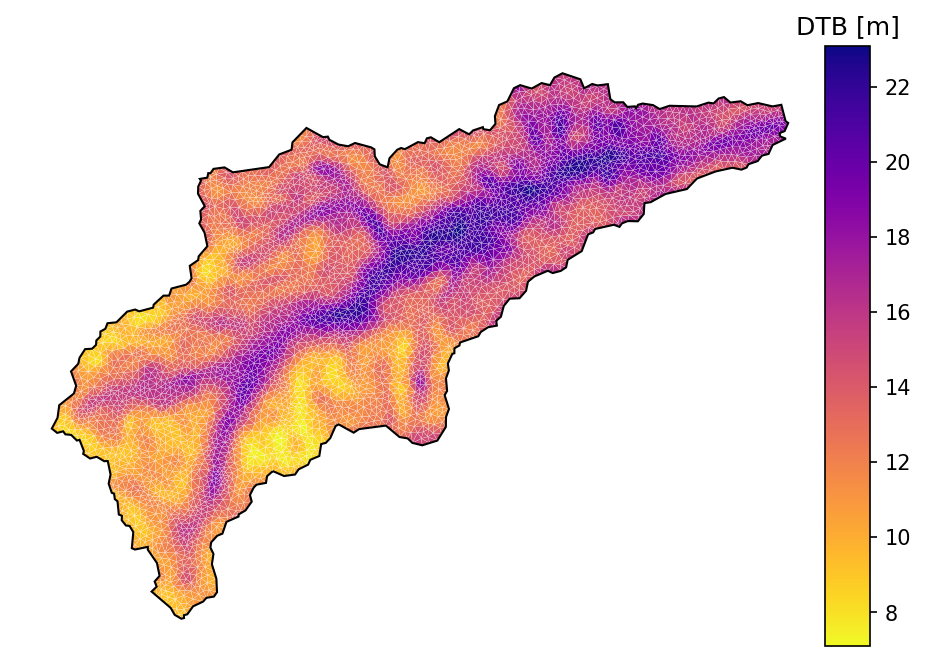

In [41]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(6,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
# ax2 = ax.inset_axes([0.58,0.45,0.3,0.3])
# cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

# bxlim = (591000., 600000.)
# bylim = (94000., 103000.)

mp = workflow.plot.triangulation(DTB_3d, mesh_tris, crs, ax=ax, 
                                 color='elevation', cmap = 'plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')
# ax.set_xlim([770000, 800000])
# ax.set_ylim([4520000, 4550000])

# mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color='elevation', edgecolor='white', linewidth=0.5)
# workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax2, color='aqua', linewidth=1.5)
# ax2.set_xlim(bxlim)
# ax2.set_ylim(bylim)
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_aspect('equal', 'datalim')

# ax.indicate_inset_zoom(ax2, edgecolor='r')

# ax.margins(0.5)
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
# scalebar1 = ScaleBar(1, location = "lower left")
# ax.add_artist(scalebar1)
# scalebar2 = ScaleBar(1, location = "upper right")

# ax2.add_artist(scalebar2)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('DTB [m]')

# fig.tight_layout()
# fig.savefig(fig_DTB, dpi = 300, transparent = True)

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

In [42]:
total_tckness = np.ceil(DTB_mesh.max())
logging.info(f'total thickness: {total_tckness} m')

2021-06-08 21:24:37,383 - root - INFO: total thickness: 25.0 m


In [43]:
ele_per_layer = mesh_tris.shape[0]

In [44]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []
z_top = []

z = 0.0
z_top.append(z)
# -- soil layer --
#  top 6 m
#  5 cm initial top cell
#  10 cells
#  expanding dz, growing with depth
ncells = 6
dz = 0.05
layer_dz = 2 # total top thickness

tele = workflow.mesh.telescope_factor(ncells, dz, layer_dz)
logging.info("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_color)
    z += dz
#     dz *= tele
    dz = round(dz * tele, 2)
    z_top.append(z)    

# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
dz = 2.0

geo_ncells = int(np.ceil((total_tckness-z)/dz))
for i in range(geo_ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
#     ilayer_id = 900 + ncells + i + 1
#     layer_mat_ids.append(ilayer_id * np.ones_like(soil_color))
    layer_mat_ids.append(geo_color)
    z += dz    
    z_top.append(z)

# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2021-06-08 21:24:37,463 - root - INFO: Converged?: ratio = 1.7857749000436356, layer z (target = 2) = -5.985434370359144e-12
2021-06-08 21:24:37,464 - root - INFO: Got telescoping factor: 1.7857749000436356
2021-06-08 21:24:37,465 - root - INFO: Cell summary:
2021-06-08 21:24:37,465 - root - INFO: ------------------------------------------------------------
2021-06-08 21:24:37,466 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2021-06-08 21:24:37,466 - root - INFO: ------------------------------------------------------------
2021-06-08 21:24:37,466 - root - INFO:  00 	| 00 	| 75342 	|   0.050000 	|   0.000000
2021-06-08 21:24:37,467 - root - INFO:  01 	| 01 	| 75342 	|   0.090000 	|   0.050000
2021-06-08 21:24:37,467 - root - INFO:  02 	| 02 	| 75342 	|   0.160000 	|   0.140000
2021-06-08 21:24:37,468 - root - INFO:  03 	| 03 	| 75342 	|   0.290000 	|   0.300000
2021-06-08 21:24:37,468 - root - INFO:  04 	| 04 	| 75342 	|   0.520000 	|   0.590000
2021-06-08 21:24:37,468 - root - INFO

In [45]:
logging.info(f"No of cells: {len(layer_data)*ele_per_layer}")

2021-06-08 21:24:37,517 - root - INFO: No of cells: 142488


**add layer ids**

In [121]:
# mat_ids = np.arange(1, len(layer_data)+1) # layer ids
# new_layer_mat_ids = [np.array([i]*ele_per_layer, dtype=int) for i in mat_ids]
# layer_mat_ids, len(layer_mat_ids), layer_mat_ids[0].shape
# new_layer_mat_ids, len(new_layer_mat_ids), new_layer_mat_ids[0].shape
# layer_mat_ids = new_layer_mat_ids

### add bedrock material

In [83]:
bedrock_id = 999
riverbed_id = 100
unique_mat_ids = geo_prop_df.index.tolist() + soil_prop_df.index.tolist() + [bedrock_id] + [riverbed_id]

if len(unique_mat_ids) != len(set(unique_mat_ids)): 
    raise RuntimeWarning('Common id is found in either soil/geol/bedrock/riverbed ids!')

In [84]:
# get depth below top cell face
z_top = np.asarray(z_top) # relative distance to surface
z_center = z_top[:-1] + (z_top[1:]-z_top[:-1])/2 # cell center distance for each layer

In [85]:
mat_ids = np.stack(layer_mat_ids)

for icol in np.arange(mat_ids.shape[1])[:]:
#     idem = DEM_mesh[icol]
    idtb = DTB_mesh[icol]
#     ielev = idem - z_center
    idx = z_center > idtb
    
    # assign 999 to bedrock
    mat_ids[idx, icol] = bedrock_id

### add riverbed material

In [86]:
alluvium_tck = 0.5 # m
layer_idx = sum(z_center < alluvium_tck) # find the top layers with a total thickness < 0.5 m
for ilayer in range(layer_idx):
    mat_ids[ilayer, river_idx] = riverbed_id

### extrusion

Extruded 3-D mesh has layer ordered bottom up?

In [87]:
layer_mat_ids = [mat_ids[row, :] for row in np.arange(mat_ids.shape[0])]

In [122]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

### add sidesets from land cover type

In [123]:
ss_names = [m3.side_sets[i].name for i in range(len(m3.side_sets))]
ss_ids = [m3.side_sets[i].setid for i in range(len(m3.side_sets))]

In [124]:
assert(ss_names.index('surface')==1)# surface sideset has id=1
# add back on land cover side sets
surf_ss = m3.side_sets[1] 

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

**group landcover types**

In [106]:
# lc_dict = {j:i for i,j in zip(nlcd_indices, nlcd_labels)}

# groups = {
#     'evergreen forest' : [lc_dict['Evergreen Forest'], lc_dict['Mixed Forest'], lc_dict['Deciduous Forest']],
#     'shrub': [lc_dict[i] for i in ['Shrub/Scrub', 'Grassland/Herbaceous', 'Woody Wetlands', 'Pasture/Hay',
#                                   'Emergent Herbaceous Wetlands']],
#     'other': [lc_dict[i] for i in ['Barren Land', 'Developed, Open Space', 'Developed, Low Intensity', 
#                                   'Developed, Medium Intensity', 'Developed, High Intensity', 'Open Water']]
# }

# group_ids = {
#     'evergreen forest' : 97,
#     'shrub': 98,
#     'other': 99
# }

# for iname,iid in group_ids.items():
#     idx = np.concatenate([np.where(lc == i)[0] for i in groups[iname]])

#     ss = workflow.mesh.SideSet(iname, iid, 
#                             [surf_ss.elem_list[w] for w in idx],
#                             [surf_ss.side_list[w] for w in idx])        
#     m3.side_sets.append(ss)    

## save to exodus file

In [125]:
# save to disk
try:
    os.remove(fname_final_mesh)
except FileNotFoundError:
    pass
m3.write_exodus(fname_final_mesh)

Opening exodus file: ./meshes/American_final_mesh-250m-layerID.exo
Closing exodus file: ./meshes/American_final_mesh-250m-layerID.exo
